<a href="https://colab.research.google.com/github/evpozdniakov/ds_projects/blob/master/hw10/clusterization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

In [2]:
cc_data = pd.read_csv('./data/CC GENERAL.csv', index_col='CUST_ID')
cc_data.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
CUST_ID,,,,,,,,,,,,,,,,,
C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [3]:
cc = cc_data.copy()

Теперь приступим к анализу данных. По традиции начнём его с проверки данных на наличие пропущенных значений. Сколько всего пропусков в данных?

In [4]:
cc.isna().sum().sum()

314

Заполните все пропуски средними арифметическими для признаков. Каким будет среднее арифметическое для признака MINIMUM_PAYMENTS (если считать после заполнения пропущенных значений)? Округлите результат до двух знаков после точки-разделителя.

In [5]:
cc.fillna({
    'MINIMUM_PAYMENTS': cc['MINIMUM_PAYMENTS'].mean(),
    'CREDIT_LIMIT': cc['CREDIT_LIMIT'].mean(),
}, inplace=True)

round(cc['MINIMUM_PAYMENTS'].mean(), 2)

864.21

Теперь нормализуйте данные с помощью StandardScaler(). Для получившейся матрицы нормализованных признаков выведите самое первое значение в самой первой строке (X_norm[0][0]). Округлите до двух знаков после точки-разделителя.

In [6]:
from sklearn import preprocessing as ce

X = cc.copy()
columns_to_scale = X.columns.to_list()
# create scaler once and fit it to some initial data
scaler = ce.StandardScaler()

scaler.fit(X[columns_to_scale])
# use the scaler for data (once or many times)
ndarr = scaler.transform(X[columns_to_scale])
# create a DataFrame out of ndarr
norm_df = pd.DataFrame(ndarr, columns=columns_to_scale).set_index(X.index)
# update the transformed columns data
X.loc[:, columns_to_scale] = norm_df[columns_to_scale]

round(X.values[0][0], 2)

-0.73

Теперь можем приступать к кластеризации. Начнём с самого простого и популярного метода — k-means. Для того чтобы его применить, необходимо узнать число кластеров. Наилучший способ сделать это — применить коэффициент силуэта. Найдите с его помощью оптимальное количество кластеров, перебрав диапазон от 2 до 9 включительно. В этом и следующем заданиях для параметра random_state возьмём значение 42.

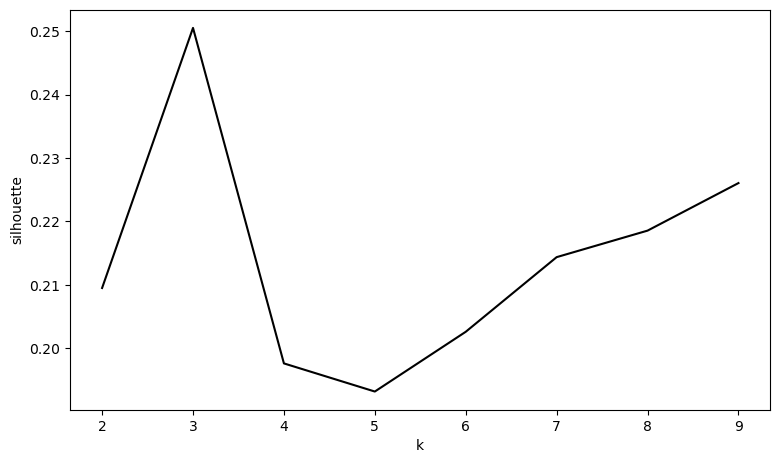

In [7]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

def figax(name, figsize=(7, 4), rowcol=None, axes=[0,0,1,1]):
    fig = plt.figure(name, figsize=figsize)

    if rowcol is None:
        ax = fig.add_axes(axes)
    else:
        rows, cols = rowcol
        ax = fig.subplots(rows, cols)

    return fig, ax


def draw_silhouette(X, k_range=range(2, 10)):
    def get_silhouette(X, k):
        k_means = KMeans(n_clusters=k, random_state=42)
        k_means.fit(X)
        return silhouette_score(X, k_means.labels_)

    silhouette_data = pd.DataFrame({
        "k": k_range,
        "silhouette": [get_silhouette(X, k) for k in k_range],
    })

    fig, ax = figax('silhouette')
    sns.lineplot(ax=ax, data=silhouette_data, x='k', y='silhouette', color='black')
    fig.set_facecolor('white')

draw_silhouette(X)

Теперь реализуем непосредственно кластеризацию k-means с оптимальным количеством кластеров, которое мы определили в предыдущем задании.

Сколько человек оказалось в самой малочисленной группе?

In [8]:
k_means = KMeans(
    n_clusters=3, # количество кластеров, default 8
    random_state=42,
)

k_means.fit(X);

labels = pd.Series(k_means.labels_)

labels.value_counts()

0    6118
1    1597
2    1235
dtype: int64

Попробуем применить DBSCAN. Для начала реализуйте его с параметрами по умолчанию.

Сколько кластеров было выделено?

In [9]:
from sklearn.cluster import DBSCAN

clustering = DBSCAN()
clustering.fit(X);

labels = pd.Series(clustering.labels_)
labels = labels.value_counts().values
labels_count = len(labels)

print(f'Labels: {labels}')
print(f'Labels count: {labels_count}')

Labels: [6627 1698  234   60   34   30   23   23   18   14   13   11   10    9
    9    8    8    8    7    7    7    7    6    6    6    6    5    5
    5    5    5    5    5    5    5    5    4    4    3]
Labels count: 39


In [10]:
print(f'Clusters count: {labels_count - 1}')

Clusters count: 38


В предыдущем задании получилось очень много кластеров. Возможно, это случилось потому, что мы взяли параметры по умолчанию, а результат алгоритма DBSCAN, как вы помните, очень чувствителен к ним.

Давайте попробуем с помощью цикла перебрать параметр `eps` по значениям, заданным как `np.arange(0.1,3,0.2)`, а параметр `min_samples` — по значениям, заданным как `range(1,20,4)`. Найдите комбинацию, которая даёт максимальное значение коэффициента силуэта.

In [11]:
np.arange(0.1, 3, 0.2)

array([0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9, 2.1, 2.3, 2.5,
       2.7, 2.9])

In [12]:
def calc_silhouette(X):
    def get_silhouette(X, eps, min_samples):
        clustering = DBSCAN(
            min_samples=min_samples, # минимальное кол-во соседей центральной точки
            eps=eps, # максимальный радиус до соседней точки
        )
        clustering.fit(X);
        return silhouette_score(X, clustering.labels_)

    data = list()

    for min_samples in range(1, 20, 4):
        for eps in np.arange(0.1, 3, 0.2):
            silhouette = get_silhouette(X, eps, min_samples)
            # print(f'min_samples: {min_samples}, eps: {eps}, silhouette: {round(silhouette, 3)}')
            data.append(list([min_samples, eps, silhouette]))

    return data;

data = calc_silhouette(X)

In [13]:
dbscan_silhouette = pd.DataFrame(
    data=data,
    columns=['min_samples', 'eps', 'silhouette'],
)

dbscan_silhouette.sort_values('silhouette', ascending=False)


,min_samples,eps,silhouette
29,5,2.9,0.617345
44,9,2.9,0.603811
59,13,2.9,0.595399
28,5,2.7,0.592182
74,17,2.9,0.591924
...,...,...,...
6,1,1.3,-0.399305
31,9,0.3,-0.404209
16,5,0.3,-0.424475
18,5,0.7,-0.438837


Теперь давайте реализуем агломеративную иерархическую кластеризацию. Переберите количество кластеров в диапазоне от 3 до 9 включительно и найдите то их число, которое будет давать максимальный коэффициент силуэта.

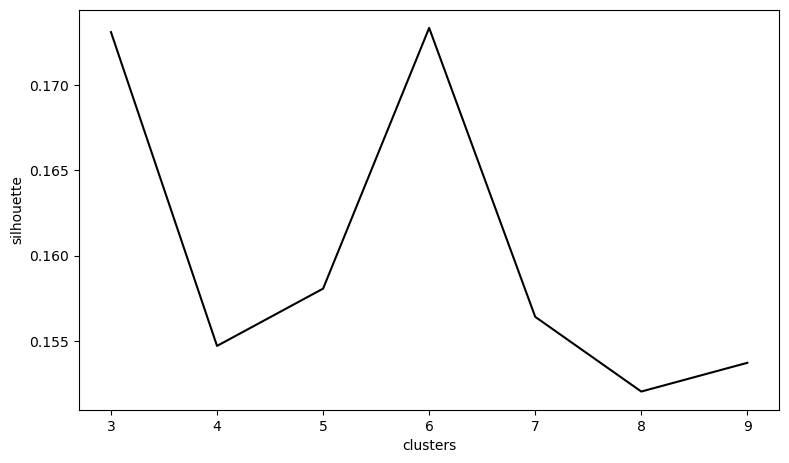

In [14]:
from sklearn.cluster import AgglomerativeClustering

def draw_silhouette(X):
    def get_silhouette(X, n_clusters):
        # linkage = 'ward' # or 'complete', 'average', 'single'
        # affinity = 'euclidean' # or 'l1', 'cosine'

        clustering = AgglomerativeClustering(
            n_clusters=n_clusters,
            # linkage=linkage,
            # affinity=affinity,
        )

        clustering.fit(X)

        return silhouette_score(X, clustering.labels_)

    clusters = range(3, 10)

    silhouette_data = pd.DataFrame({
        "clusters": clusters,
        "silhouette": [get_silhouette(X, n) for n in clusters],
    })

    fig, ax = figax('silhouette')
    sns.lineplot(ax=ax, data=silhouette_data, x='clusters', y='silhouette', color='black')
    fig.set_facecolor('white')

    return silhouette_data

silhouette_data = draw_silhouette(X)


In [15]:
silhouette_data.sort_values('silhouette', ascending=False)

,clusters,silhouette
3,6,0.173356
0,3,0.173110
2,5,0.158069
4,7,0.156415
1,4,0.154709
6,9,0.153719
5,8,0.152035


Сколько будет наблюдений в самом многочисленном классе, если мы обучим на наших данных модель агломеративной иерархической кластеризации с количеством кластеров, полученным в предыдущем задании?

In [16]:
n_clusters = 6

clustering = AgglomerativeClustering(
    n_clusters=n_clusters,
)

clustering.fit(X)

labels = pd.Series(clustering.labels_)
labels = labels.value_counts().values
labels_count = len(labels)

print(f'Labels: {labels}')
print(f'Labels count: {labels_count}')

Labels: [3946 2931  864  722  464   23]
Labels count: 6


Давайте визуализируем результаты кластеризации k-means, отобразив два признака — количество покупок и кредитный лимит:

<AxesSubplot: xlabel='CREDIT_LIMIT', ylabel='PURCHASES'>

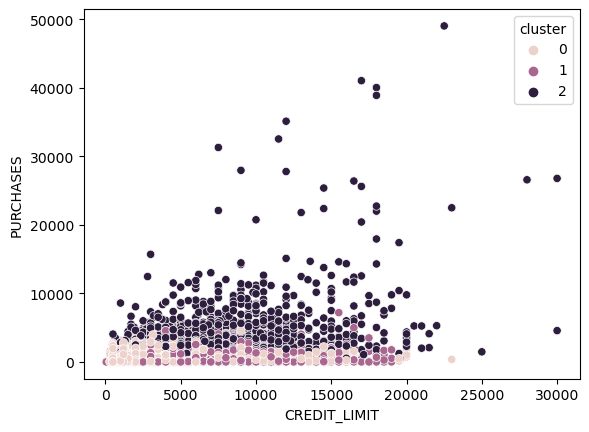

In [17]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X)
cc.loc[:, 'cluster'] = kmeans.labels_

sns.scatterplot(data=cc, x='CREDIT_LIMIT', y='PURCHASES', hue='cluster')